In [25]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [29]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Added augmentation to reduce overfitting
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [31]:
# Function to balance dataset
def balance_dataset(data):
    """Balance positive and negative samples by oversampling the minority class."""
    positive_samples = data[data['label'] == 1]
    negative_samples = data[data['label'] == 0]
    if len(positive_samples) > len(negative_samples):
        negative_samples = negative_samples.sample(len(positive_samples), replace=True)
    else:
        positive_samples = positive_samples.sample(len(negative_samples), replace=True)
    balanced_data = pd.concat([positive_samples, negative_samples]).sample(frac=1).reset_index(drop=True)
    return balanced_data

# Custom Dataset class for MURA with balancing
class MURA_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, body_part, transform=None):
        # Load and filter data for the specific body part
        self.data = pd.read_csv(csv_file, header=None, names=['path', 'label'])
        self.data = self.data[self.data['path'].str.contains(body_part)]
        
        # Balance the dataset
        self.data = balance_dataset(self.data)
        self.root_dir = root_dir
        self.transform = transform
        
        # Create a list of all image paths and their corresponding labels
        self.image_paths = []
        self.labels = []
        
        for idx, row in self.data.iterrows():
            study_path = os.path.join(self.root_dir, row['path'].replace('MURA-v1.1/', ''))
            if os.path.exists(study_path):
                try:
                    for img_name in os.listdir(study_path):
                        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                            self.image_paths.append(os.path.join(study_path, img_name))
                            self.labels.append(row['label'])
                except PermissionError:
                    print(f"Permission denied accessing {study_path}")
                    continue
            else:
                print(f"Path does not exist: {study_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            if self.transform:
                image = self.transform(Image.new('RGB', (224, 224), (0, 0, 0)))
            else:
                image = Image.new('RGB', (224, 224), (0, 0, 0))
            return image, 0

In [33]:
# Custom ResNet18 model with dropout
class ResNet18WithDropout(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.2):
        super(ResNet18WithDropout, self).__init__()
        try:
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        except:
            self.backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [35]:
# Function to load trained model
def load_trained_model(model_path, device, dropout_rate=0.2):
    model = ResNet18WithDropout(num_classes=2, dropout_rate=dropout_rate)
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model = model.to(device)
    return model

# Function to check if model exists
def model_exists(body_part):
    model_path = f'resnet18_{body_part}_final.pth'
    return os.path.exists(model_path)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, body_part, dataset_type="Validation"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    color_map = 'Blues' if dataset_type == "Validation" else 'Greens'
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_map,
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'])
    plt.title(f'{dataset_type} Data Confusion Matrix - {body_part}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [37]:
# Function to evaluate model
def evaluate_model(model, dataloader, device, body_part, dataset_type="Validation"):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f"Evaluating {body_part} ({dataset_type})")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

# Training function
def train_models():
    body_parts = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
    root_dir = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1"
    train_csv = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1\train_labeled_studies.csv"
    
    trained_parts = [bp for bp in body_parts if model_exists(bp)]
    remaining_parts = [bp for bp in body_parts if not model_exists(bp)]
    
    if trained_parts:
        print(f"Already trained models found for: {', '.join(trained_parts)}")
        print(f"Resuming training for remaining parts: {', '.join(remaining_parts)}")
    else:
        print("No existing models found. Starting fresh training.")
    
    if not remaining_parts:
        print("All body parts already trained! No further training needed.")
        return
    
    for body_part in remaining_parts:
        print(f"\nTraining model for {body_part}...")
        dataset = MURA_Dataset(csv_file=train_csv, root_dir=root_dir, body_part=body_part, transform=transform)
        if len(dataset) == 0:
            print(f"No images found for {body_part}. Skipping...")
            continue
        print(f"Found {len(dataset)} images for {body_part} (balanced)")
        
        loader = DataLoader(dataset, batch_size=min(32, len(dataset)), shuffle=True, num_workers=0)
        model = ResNet18WithDropout(num_classes=2, dropout_rate=0.2)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        for epoch in range(25):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            epoch_desc = f"Epoch {epoch+1}/25 [{body_part}]"
            progress_bar = tqdm(loader, desc=epoch_desc, leave=False)
            
            for batch_idx, (images, labels) in enumerate(progress_bar):
                try:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    current_loss = running_loss / (batch_idx + 1)
                    current_acc = 100 * correct / total if total > 0 else 0
                    progress_bar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.2f}%'})
                except RuntimeError as e:
                    print(f"Error in batch {batch_idx}: {e}")
                    continue
            
            epoch_loss = running_loss / len(loader) if len(loader) > 0 else 0
            epoch_acc = 100 * correct / total if total > 0 else 0
            print(f'Epoch {epoch+1}/25 for {body_part} completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        
        model_save_path = f'resnet18_{body_part}_final.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'final_loss': epoch_loss,
            'final_accuracy': epoch_acc,
            'epochs_trained': 25,
            'body_part': body_part,
            'dropout_rate': 0.2
        }, model_save_path)
        print(f'✓ Model for {body_part} saved to {model_save_path}')
        print(f'✓ {body_part} training completed successfully!')
    
    print(f"\n🎉 Training complete! All models saved:")
    for body_part in body_parts:
        if model_exists(body_part):
            print(f"  ✓ resnet18_{body_part}_final.pth")
        else:
            print(f"  ✗ {body_part} - Not trained")

In [45]:
# Function to evaluate on training data
def evaluate_training_data():
    root_dir = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1"
    train_csv = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1\train_labeled_studies.csv"
    body_parts = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
    
    if not os.path.exists(root_dir) or not os.path.exists(train_csv):
        print(f"Required files not found!")
        return None
    
    training_results = {}
    print("🏋️ Starting Model Evaluation on Training Data")
    print("=" * 60)
    
    for body_part in body_parts:
        model_path = f'resnet18_{body_part}_final.pth'
        if not os.path.exists(model_path):
            print(f"❌ Model not found for {body_part}: {model_path}")
            continue
        
        print(f"\n📊 Evaluating {body_part} on training data...")
        train_dataset = MURA_Dataset(csv_file=train_csv, root_dir=root_dir, body_part=body_part, transform=transform)
        if len(train_dataset) == 0:
            print(f"⚠️ No training images found for {body_part}")
            continue
        
        print(f"📁 Found {len(train_dataset)} training images for {body_part}")
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        try:
            model = load_trained_model(model_path, device, dropout_rate=0.2)
            print(f"✅ Model loaded successfully for {body_part}")
            y_pred, y_true, y_prob = evaluate_model(model, train_loader, device, body_part, "Training")
            metrics = calculate_metrics(y_true, y_pred)
            training_results[body_part] = metrics
            
            print(f"\n📈 Training Data Results for {body_part}:")
            print(f"   Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
            print(f"   Precision: {metrics['precision']:.4f}")
            print(f"   Recall:    {metrics['recall']:.4f}")
            print(f"   F1-Score:  {metrics['f1_score']:.4f}")
            plot_confusion_matrix(y_true, y_pred, body_part, "Training")
            print(f"\n📋 Training Data Classification Report for {body_part}:")
            print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))
        except Exception as e:
            print(f"❌ Error during training evaluation for {body_part}: {e}")
            continue
    
    if training_results:
        print("\n" + "="*60)
        print("📊 TRAINING DATA EVALUATION SUMMARY")
        print("="*60)
        training_df = pd.DataFrame(training_results).T.round(4)
        print(training_df)
        
        plt.figure(figsize=(12, 8))
        training_df.plot(kind='bar', ax=plt.gca(), color=['green', 'lightgreen', 'darkgreen', 'forestgreen'])
        plt.title('Training Data Performance Across Body Parts')
        plt.ylabel('Score')
        plt.xlabel('Body Parts')
        plt.legend(title='Metrics')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        avg_accuracy = training_df['accuracy'].mean()
        std_accuracy = training_df['accuracy'].std()
        best_training = training_df['accuracy'].idxmax()
        worst_training = training_df['accuracy'].idxmin()
        
        print(f"\n📊 Training Performance Statistics:")
        print(f"   Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
        print(f"   Best Training Performance: {best_training} ({training_df.loc[best_training, 'accuracy']:.4f})")
        print(f"   Lowest Training Performance: {worst_training} ({training_df.loc[worst_training, 'accuracy']:.4f})")
        return training_df
    else:
        print("\n❌ No models were successfully evaluated on training data!")
        return None

# Function to evaluate on validation data
def evaluate_validation_data():
    root_dir = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1"
    valid_csv = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1\valid_labeled_studies.csv"
    body_parts = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
    
    if not os.path.exists(root_dir) or not os.path.exists(valid_csv):
        print(f"Required files not found!")
        return None
    
    validation_results = {}
    print("🔍 Starting Model Evaluation on Validation Data")
    print("=" * 60)
    
    for body_part in body_parts:
        model_path = f'resnet18_{body_part}_final.pth'
        if not os.path.exists(model_path):
            print(f"❌ Model not found for {body_part}: {model_path}")
            continue
        
        print(f"\n📊 Evaluating {body_part}...")
        val_dataset = MURA_Dataset(csv_file=valid_csv, root_dir=root_dir, body_part=body_part, transform=transform)
        if len(val_dataset) == 0:
            print(f"⚠️ No validation images found for {body_part}")
            continue
        
        print(f"📁 Found {len(val_dataset)} validation images for {body_part}")
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        try:
            model = load_trained_model(model_path, device, dropout_rate=0.2)
            print(f"✅ Model loaded successfully for {body_part}")
            y_pred, y_true, y_prob = evaluate_model(model, val_loader, device, body_part, "Validation")
            metrics = calculate_metrics(y_true, y_pred)
            validation_results[body_part] = metrics
            
            print(f"\n📈 Results for {body_part}:")
            print(f"   Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
            print(f"   Precision: {metrics['precision']:.4f}")
            print(f"   Recall:    {metrics['recall']:.4f}")
            print(f"   F1-Score:  {metrics['f1_score']:.4f}")
            plot_confusion_matrix(y_true, y_pred, body_part, "Validation")
            print(f"\n📋 Detailed Classification Report for {body_part}:")
            print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))
        except Exception as e:
            print(f"❌ Error during evaluation for {body_part}: {e}")
            continue
    
    if validation_results:
        print("\n" + "="*60)
        print("📊 VALIDATION DATA EVALUATION SUMMARY")
        print("="*60)
        summary_df = pd.DataFrame(validation_results).T.round(4)
        print(summary_df)
        
        plt.figure(figsize=(12, 8))
        summary_df.plot(kind='bar', ax=plt.gca())
        plt.title('Model Performance Comparison Across Body Parts')
        plt.ylabel('Score')
        plt.xlabel('Body Parts')
        plt.legend(title='Metrics')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        best_accuracy = summary_df['accuracy'].max()
        worst_accuracy = summary_df['accuracy'].min()
        best_model = summary_df['accuracy'].idxmax()
        worst_model = summary_df['accuracy'].idxmin()
        avg_accuracy = summary_df['accuracy'].mean()
        std_accuracy = summary_df['accuracy'].std()
        
        print(f"\n🏆 Best performing model: {best_model} (Accuracy: {best_accuracy:.4f})")
        print(f"⚠️ Lowest performing model: {worst_model} (Accuracy: {worst_accuracy:.4f})")
        print(f"📊 Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
        return summary_df
    else:
        print("\n❌ No models were successfully evaluated!")
        return None

🚀 Starting MURA Classification Pipeline with Dropout and Balancing

📚 STEP 1: Training Models
Already trained models found for: XR_ELBOW
Resuming training for remaining parts: XR_FINGER, XR_FOREARM, XR_HAND, XR_HUMERUS, XR_SHOULDER, XR_WRIST

Training model for XR_FINGER...
Found 6986 images for XR_FINGER (balanced)


Epoch 1/25 for XR_FINGER completed - Loss: 0.5925, Accuracy: 68.67%


Epoch 2/25 for XR_FINGER completed - Loss: 0.5542, Accuracy: 72.20%


Epoch 3/25 for XR_FINGER completed - Loss: 0.5346, Accuracy: 74.05%


Epoch 4/25 for XR_FINGER completed - Loss: 0.5370, Accuracy: 72.49%


Epoch 5/25 for XR_FINGER completed - Loss: 0.5142, Accuracy: 75.29%


Epoch 6/25 for XR_FINGER completed - Loss: 0.5045, Accuracy: 75.61%


Epoch 7/25 for XR_FINGER completed - Loss: 0.4916, Accuracy: 76.58%


Epoch 8/25 for XR_FINGER completed - Loss: 0.4910, Accuracy: 77.24%


Epoch 9/25 for XR_FINGER completed - Loss: 0.4753, Accuracy: 77.53%


Epoch 10/25 for XR_FINGER completed - Loss: 0.4760, Accuracy: 77.60%


Epoch 11/25 for XR_FINGER completed - Loss: 0.4656, Accuracy: 78.53%


Epoch 12/25 for XR_FINGER completed - Loss: 0.4581, Accuracy: 78.39%


Epoch 13/25 for XR_FINGER completed - Loss: 0.4534, Accuracy: 79.02%


Epoch 14/25 for XR_FINGER completed - Loss: 0.4452, Accuracy: 79.40%


Epoch 15/25 for XR_FINGER completed - Loss: 0.4469, Accuracy: 79.60%


Epoch 16/25 for XR_FINGER completed - Loss: 0.4394, Accuracy: 79.30%


Epoch 17/25 for XR_FINGER completed - Loss: 0.4383, Accuracy: 79.60%


Epoch 18/25 for XR_FINGER completed - Loss: 0.4203, Accuracy: 80.62%


Epoch 19/25 for XR_FINGER completed - Loss: 0.4154, Accuracy: 80.68%


Epoch 20/25 for XR_FINGER completed - Loss: 0.4119, Accuracy: 81.43%


Epoch 21/25 for XR_FINGER completed - Loss: 0.3987, Accuracy: 82.41%


Epoch 22/25 for XR_FINGER completed - Loss: 0.4000, Accuracy: 82.09%


Epoch 23/25 for XR_FINGER completed - Loss: 0.3952, Accuracy: 82.74%


Epoch 24/25 for XR_FINGER completed - Loss: 0.3882, Accuracy: 83.08%


Epoch 25/25 for XR_FINGER completed - Loss: 0.3762, Accuracy: 83.65%


✓ Model for XR_FINGER saved to resnet18_XR_FINGER_final.pth
✓ XR_FINGER training completed successfully!

Training model for XR_FOREARM...
Found 2503 images for XR_FOREARM (balanced)


Epoch 1/25 for XR_FOREARM completed - Loss: 0.6473, Accuracy: 65.24%


Epoch 2/25 for XR_FOREARM completed - Loss: 0.5862, Accuracy: 68.00%


Epoch 3/25 for XR_FOREARM completed - Loss: 0.5609, Accuracy: 71.79%


Epoch 4/25 for XR_FOREARM completed - Loss: 0.5338, Accuracy: 74.35%


Epoch 5/25 for XR_FOREARM completed - Loss: 0.5057, Accuracy: 76.59%


Epoch 6/25 for XR_FOREARM completed - Loss: 0.4981, Accuracy: 77.15%


Epoch 7/25 for XR_FOREARM completed - Loss: 0.4703, Accuracy: 78.31%


Epoch 8/25 for XR_FOREARM completed - Loss: 0.4625, Accuracy: 79.11%


Epoch 9/25 for XR_FOREARM completed - Loss: 0.4468, Accuracy: 80.10%


Epoch 10/25 for XR_FOREARM completed - Loss: 0.4435, Accuracy: 79.74%


Epoch 11/25 for XR_FOREARM completed - Loss: 0.4330, Accuracy: 81.34%


Epoch 12/25 for XR_FOREARM completed - Loss: 0.4287, Accuracy: 81.10%


Epoch 13/25 for XR_FOREARM completed - Loss: 0.4182, Accuracy: 81.30%


Epoch 14/25 for XR_FOREARM completed - Loss: 0.4278, Accuracy: 81.46%


Epoch 15/25 for XR_FOREARM completed - Loss: 0.4113, Accuracy: 81.74%


Epoch 16/25 for XR_FOREARM completed - Loss: 0.3933, Accuracy: 82.46%


Epoch 17/25 for XR_FOREARM completed - Loss: 0.3907, Accuracy: 83.42%


Epoch 18/25 for XR_FOREARM completed - Loss: 0.3508, Accuracy: 84.82%


Epoch 19/25 for XR_FOREARM completed - Loss: 0.3639, Accuracy: 84.14%


Epoch 20/25 for XR_FOREARM completed - Loss: 0.3496, Accuracy: 85.46%


Epoch 21/25 for XR_FOREARM completed - Loss: 0.3387, Accuracy: 85.78%


Epoch 22/25 for XR_FOREARM completed - Loss: 0.3384, Accuracy: 86.78%


Epoch 23/25 for XR_FOREARM completed - Loss: 0.3398, Accuracy: 85.14%


Epoch 24/25 for XR_FOREARM completed - Loss: 0.3240, Accuracy: 86.22%


Epoch 25/25 for XR_FOREARM completed - Loss: 0.3138, Accuracy: 87.30%


✓ Model for XR_FOREARM saved to resnet18_XR_FOREARM_final.pth
✓ XR_FOREARM training completed successfully!

Training model for XR_HAND...
Found 8356 images for XR_HAND (balanced)


Epoch 1/25 for XR_HAND completed - Loss: 0.6688, Accuracy: 59.07%


Epoch 2/25 for XR_HAND completed - Loss: 0.6240, Accuracy: 65.39%


Epoch 3/25 for XR_HAND completed - Loss: 0.6099, Accuracy: 67.36%


Epoch 4/25 for XR_HAND completed - Loss: 0.5784, Accuracy: 70.18%


Epoch 5/25 for XR_HAND completed - Loss: 0.5657, Accuracy: 71.36%


Epoch 6/25 for XR_HAND completed - Loss: 0.5505, Accuracy: 72.09%


Epoch 7/25 for XR_HAND completed - Loss: 0.5374, Accuracy: 74.38%


Epoch 8/25 for XR_HAND completed - Loss: 0.5279, Accuracy: 74.52%


Epoch 9/25 for XR_HAND completed - Loss: 0.5135, Accuracy: 75.72%


Epoch 10/25 for XR_HAND completed - Loss: 0.5181, Accuracy: 74.98%


Epoch 11/25 for XR_HAND completed - Loss: 0.5110, Accuracy: 75.61%


Epoch 12/25 for XR_HAND completed - Loss: 0.4911, Accuracy: 76.33%


Epoch 13/25 for XR_HAND completed - Loss: 0.4711, Accuracy: 77.87%


Epoch 14/25 for XR_HAND completed - Loss: 0.4661, Accuracy: 78.69%


Epoch 15/25 for XR_HAND completed - Loss: 0.4549, Accuracy: 78.85%


Epoch 16/25 for XR_HAND completed - Loss: 0.4467, Accuracy: 80.07%


Epoch 17/25 for XR_HAND completed - Loss: 0.4305, Accuracy: 80.46%


Epoch 18/25 for XR_HAND completed - Loss: 0.4197, Accuracy: 81.21%


Epoch 19/25 for XR_HAND completed - Loss: 0.4232, Accuracy: 80.78%


Epoch 20/25 for XR_HAND completed - Loss: 0.3992, Accuracy: 82.36%


Epoch 21/25 for XR_HAND completed - Loss: 0.3800, Accuracy: 83.39%


Epoch 22/25 for XR_HAND completed - Loss: 0.3732, Accuracy: 83.92%


Epoch 23/25 for XR_HAND completed - Loss: 0.3602, Accuracy: 84.21%


Epoch 24/25 for XR_HAND completed - Loss: 0.3428, Accuracy: 85.59%


Epoch 25/25 for XR_HAND completed - Loss: 0.3287, Accuracy: 86.05%


✓ Model for XR_HAND saved to resnet18_XR_HAND_final.pth
✓ XR_HAND training completed successfully!

Training model for XR_HUMERUS...
Found 1392 images for XR_HUMERUS (balanced)


Epoch 1/25 for XR_HUMERUS completed - Loss: 0.6399, Accuracy: 64.58%


Epoch 2/25 for XR_HUMERUS completed - Loss: 0.5510, Accuracy: 73.06%


Epoch 3/25 for XR_HUMERUS completed - Loss: 0.5138, Accuracy: 74.78%


Epoch 4/25 for XR_HUMERUS completed - Loss: 0.5031, Accuracy: 76.15%


Epoch 5/25 for XR_HUMERUS completed - Loss: 0.4993, Accuracy: 75.65%


Epoch 6/25 for XR_HUMERUS completed - Loss: 0.4538, Accuracy: 79.31%


Epoch 7/25 for XR_HUMERUS completed - Loss: 0.4531, Accuracy: 79.09%


Epoch 8/25 for XR_HUMERUS completed - Loss: 0.4257, Accuracy: 80.24%


Epoch 9/25 for XR_HUMERUS completed - Loss: 0.4189, Accuracy: 81.68%


Epoch 10/25 for XR_HUMERUS completed - Loss: 0.4380, Accuracy: 80.68%


Epoch 11/25 for XR_HUMERUS completed - Loss: 0.4120, Accuracy: 82.26%


Epoch 12/25 for XR_HUMERUS completed - Loss: 0.4097, Accuracy: 80.53%


Epoch 13/25 for XR_HUMERUS completed - Loss: 0.3634, Accuracy: 84.48%


Epoch 14/25 for XR_HUMERUS completed - Loss: 0.3795, Accuracy: 83.62%


Epoch 15/25 for XR_HUMERUS completed - Loss: 0.3464, Accuracy: 84.84%


Epoch 16/25 for XR_HUMERUS completed - Loss: 0.3409, Accuracy: 86.42%


Epoch 17/25 for XR_HUMERUS completed - Loss: 0.3324, Accuracy: 87.21%


Epoch 18/25 for XR_HUMERUS completed - Loss: 0.3130, Accuracy: 86.71%


Epoch 19/25 for XR_HUMERUS completed - Loss: 0.2951, Accuracy: 87.57%


Epoch 20/25 for XR_HUMERUS completed - Loss: 0.2995, Accuracy: 88.79%


Epoch 21/25 for XR_HUMERUS completed - Loss: 0.2818, Accuracy: 88.29%


Epoch 22/25 for XR_HUMERUS completed - Loss: 0.2496, Accuracy: 89.51%


Epoch 23/25 for XR_HUMERUS completed - Loss: 0.2901, Accuracy: 86.28%


Epoch 24/25 for XR_HUMERUS completed - Loss: 0.2684, Accuracy: 88.58%


Epoch 25/25 for XR_HUMERUS completed - Loss: 0.2497, Accuracy: 88.72%


✓ Model for XR_HUMERUS saved to resnet18_XR_HUMERUS_final.pth
✓ XR_HUMERUS training completed successfully!

Training model for XR_SHOULDER...
Found 8657 images for XR_SHOULDER (balanced)


Epoch 1/25 for XR_SHOULDER completed - Loss: 0.6490, Accuracy: 62.94%


Epoch 2/25 for XR_SHOULDER completed - Loss: 0.6337, Accuracy: 65.21%


Epoch 3/25 for XR_SHOULDER completed - Loss: 0.6249, Accuracy: 66.09%


Epoch 4/25 for XR_SHOULDER completed - Loss: 0.6141, Accuracy: 67.28%


Epoch 5/25 for XR_SHOULDER completed - Loss: 0.6052, Accuracy: 67.98%


Epoch 6/25 for XR_SHOULDER completed - Loss: 0.6004, Accuracy: 68.59%


Epoch 7/25 for XR_SHOULDER completed - Loss: 0.5987, Accuracy: 68.49%


Epoch 8/25 for XR_SHOULDER completed - Loss: 0.5879, Accuracy: 69.47%


Epoch 9/25 for XR_SHOULDER completed - Loss: 0.5880, Accuracy: 69.99%


Epoch 10/25 for XR_SHOULDER completed - Loss: 0.5856, Accuracy: 70.08%


Epoch 11/25 for XR_SHOULDER completed - Loss: 0.5706, Accuracy: 70.98%


Epoch 12/25 for XR_SHOULDER completed - Loss: 0.5635, Accuracy: 71.61%


Epoch 13/25 for XR_SHOULDER completed - Loss: 0.5596, Accuracy: 72.15%


Epoch 14/25 for XR_SHOULDER completed - Loss: 0.5599, Accuracy: 72.01%


Epoch 15/25 for XR_SHOULDER completed - Loss: 0.5485, Accuracy: 72.67%


Epoch 16/25 for XR_SHOULDER completed - Loss: 0.5497, Accuracy: 72.69%


Epoch 17/25 for XR_SHOULDER completed - Loss: 0.5417, Accuracy: 73.41%


Epoch 18/25 for XR_SHOULDER completed - Loss: 0.5362, Accuracy: 73.82%


Epoch 19/25 for XR_SHOULDER completed - Loss: 0.5279, Accuracy: 74.46%


Epoch 20/25 for XR_SHOULDER completed - Loss: 0.5191, Accuracy: 74.95%


Epoch 21/25 for XR_SHOULDER completed - Loss: 0.5119, Accuracy: 75.12%


Epoch 22/25 for XR_SHOULDER completed - Loss: 0.5128, Accuracy: 75.23%


Epoch 23/25 for XR_SHOULDER completed - Loss: 0.4908, Accuracy: 76.60%


Epoch 24/25 for XR_SHOULDER completed - Loss: 0.4920, Accuracy: 76.94%


Epoch 25/25 for XR_SHOULDER completed - Loss: 0.4866, Accuracy: 77.09%


✓ Model for XR_SHOULDER saved to resnet18_XR_SHOULDER_final.pth
✓ XR_SHOULDER training completed successfully!

Training model for XR_WRIST...
Found 12171 images for XR_WRIST (balanced)


Epoch 1/25 for XR_WRIST completed - Loss: 0.5694, Accuracy: 69.13%


Epoch 2/25 for XR_WRIST completed - Loss: 0.4988, Accuracy: 74.55%


Epoch 3/25 for XR_WRIST completed - Loss: 0.4836, Accuracy: 76.18%


Epoch 4/25 for XR_WRIST completed - Loss: 0.4662, Accuracy: 77.78%


Epoch 5/25 for XR_WRIST completed - Loss: 0.4418, Accuracy: 79.87%


Epoch 6/25 for XR_WRIST completed - Loss: 0.4398, Accuracy: 79.65%


Epoch 7/25 for XR_WRIST completed - Loss: 0.4202, Accuracy: 80.95%


Epoch 8/25 for XR_WRIST completed - Loss: 0.4100, Accuracy: 81.74%


Epoch 9/25 for XR_WRIST completed - Loss: 0.4026, Accuracy: 82.13%


Epoch 10/25 for XR_WRIST completed - Loss: 0.3961, Accuracy: 82.11%


Epoch 11/25 for XR_WRIST completed - Loss: 0.3843, Accuracy: 83.37%


Epoch 12/25 for XR_WRIST completed - Loss: 0.3778, Accuracy: 83.31%


Epoch 13/25 for XR_WRIST completed - Loss: 0.3677, Accuracy: 83.79%


Epoch 14/25 for XR_WRIST completed - Loss: 0.3664, Accuracy: 83.76%


Epoch 15/25 for XR_WRIST completed - Loss: 0.3547, Accuracy: 84.64%


Epoch 16/25 for XR_WRIST completed - Loss: 0.3482, Accuracy: 84.90%


Epoch 17/25 for XR_WRIST completed - Loss: 0.3449, Accuracy: 85.08%


Epoch 18/25 for XR_WRIST completed - Loss: 0.3338, Accuracy: 85.97%


Epoch 19/25 for XR_WRIST completed - Loss: 0.3309, Accuracy: 85.87%


Epoch 20/25 for XR_WRIST completed - Loss: 0.3151, Accuracy: 86.63%


Epoch 21/25 for XR_WRIST completed - Loss: 0.3086, Accuracy: 86.90%


Epoch 22/25 for XR_WRIST completed - Loss: 0.3098, Accuracy: 87.09%


Epoch 23/25 for XR_WRIST completed - Loss: 0.2959, Accuracy: 87.63%


Epoch 24/25 for XR_WRIST completed - Loss: 0.2918, Accuracy: 87.93%


Epoch 25/25 for XR_WRIST completed - Loss: 0.2795, Accuracy: 88.43%


✓ Model for XR_WRIST saved to resnet18_XR_WRIST_final.pth
✓ XR_WRIST training completed successfully!

🎉 Training complete! All models saved:
  ✓ resnet18_XR_ELBOW_final.pth
  ✓ resnet18_XR_FINGER_final.pth
  ✓ resnet18_XR_FOREARM_final.pth
  ✓ resnet18_XR_HAND_final.pth
  ✓ resnet18_XR_HUMERUS_final.pth
  ✓ resnet18_XR_SHOULDER_final.pth
  ✓ resnet18_XR_WRIST_final.pth

📊 STEP 2: Evaluating on Training Data
🏋️ Starting Model Evaluation on Training Data

📊 Evaluating XR_ELBOW on training data...
📁 Found 6283 training images for XR_ELBOW


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_ELBOW


Evaluating XR_ELBOW (Training): 100%|████████████████████████████████████████████████| 197/197 [07:54<00:00,  2.41s/it]



📈 Training Data Results for XR_ELBOW:
   Accuracy:  0.8356 (83.56%)
   Precision: 0.8436
   Recall:    0.8356
   F1-Score:  0.8356


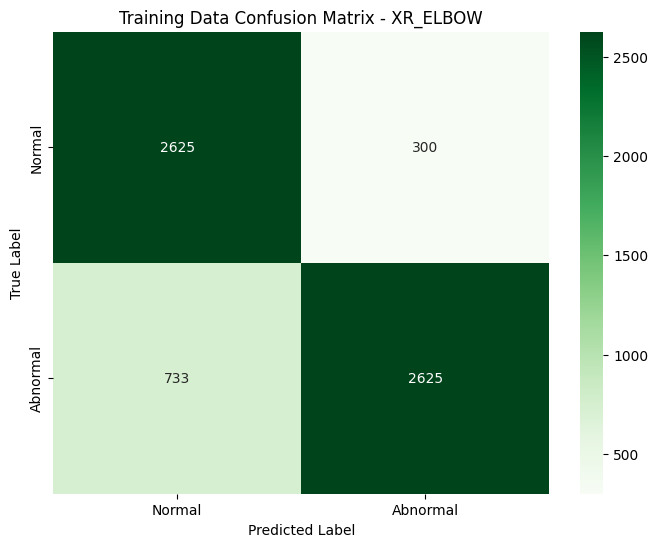


📋 Training Data Classification Report for XR_ELBOW:
              precision    recall  f1-score   support

      Normal       0.78      0.90      0.84      2925
    Abnormal       0.90      0.78      0.84      3358

    accuracy                           0.84      6283
   macro avg       0.84      0.84      0.84      6283
weighted avg       0.84      0.84      0.84      6283


📊 Evaluating XR_FINGER on training data...
📁 Found 7002 training images for XR_FINGER


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_FINGER


Evaluating XR_FINGER (Training): 100%|███████████████████████████████████████████████| 219/219 [08:57<00:00,  2.45s/it]


📈 Training Data Results for XR_FINGER:
   Accuracy:  0.8275 (82.75%)
   Precision: 0.8357
   Recall:    0.8275
   F1-Score:  0.8279


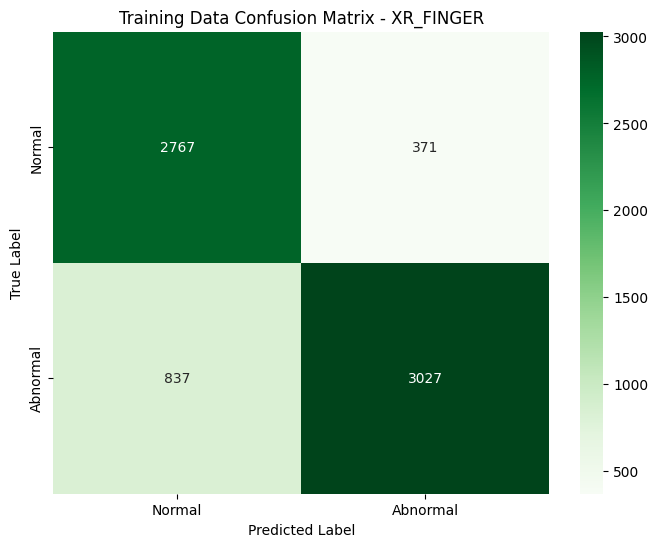


📋 Training Data Classification Report for XR_FINGER:
              precision    recall  f1-score   support

      Normal       0.77      0.88      0.82      3138
    Abnormal       0.89      0.78      0.83      3864

    accuracy                           0.83      7002
   macro avg       0.83      0.83      0.83      7002
weighted avg       0.84      0.83      0.83      7002


📊 Evaluating XR_FOREARM on training data...
📁 Found 2523 training images for XR_FOREARM


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_FOREARM


Evaluating XR_FOREARM (Training): 100%|████████████████████████████████████████████████| 79/79 [02:08<00:00,  1.63s/it]


📈 Training Data Results for XR_FOREARM:
   Accuracy:  0.8066 (80.66%)
   Precision: 0.8259
   Recall:    0.8066
   F1-Score:  0.8058


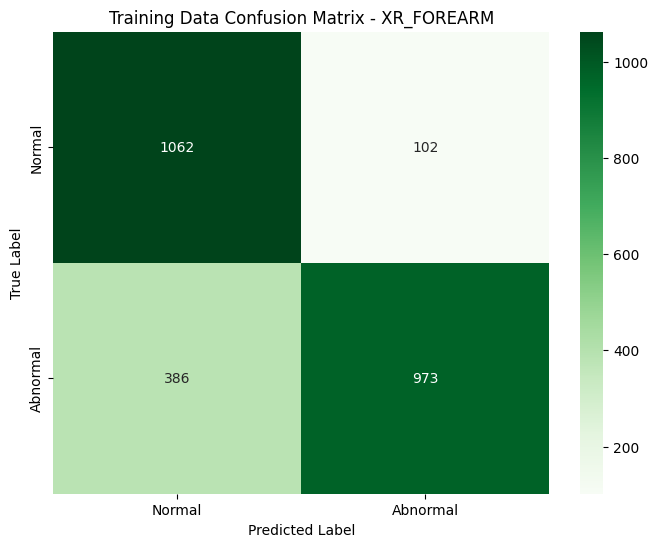


📋 Training Data Classification Report for XR_FOREARM:
              precision    recall  f1-score   support

      Normal       0.73      0.91      0.81      1164
    Abnormal       0.91      0.72      0.80      1359

    accuracy                           0.81      2523
   macro avg       0.82      0.81      0.81      2523
weighted avg       0.83      0.81      0.81      2523


📊 Evaluating XR_HAND on training data...
📁 Found 8363 training images for XR_HAND


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_HAND


Evaluating XR_HAND (Training): 100%|█████████████████████████████████████████████████| 262/262 [10:13<00:00,  2.34s/it]


📈 Training Data Results for XR_HAND:
   Accuracy:  0.8247 (82.47%)
   Precision: 0.8253
   Recall:    0.8247
   F1-Score:  0.8247


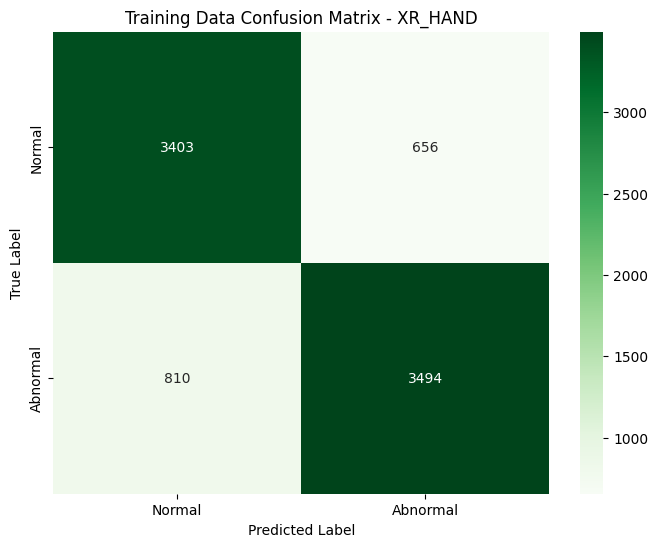


📋 Training Data Classification Report for XR_HAND:
              precision    recall  f1-score   support

      Normal       0.81      0.84      0.82      4059
    Abnormal       0.84      0.81      0.83      4304

    accuracy                           0.82      8363
   macro avg       0.82      0.83      0.82      8363
weighted avg       0.83      0.82      0.82      8363


📊 Evaluating XR_HUMERUS on training data...
📁 Found 1395 training images for XR_HUMERUS


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_HUMERUS


Evaluating XR_HUMERUS (Training): 100%|████████████████████████████████████████████████| 44/44 [00:32<00:00,  1.35it/s]


📈 Training Data Results for XR_HUMERUS:
   Accuracy:  0.7599 (75.99%)
   Precision: 0.8286
   Recall:    0.7599
   F1-Score:  0.7491


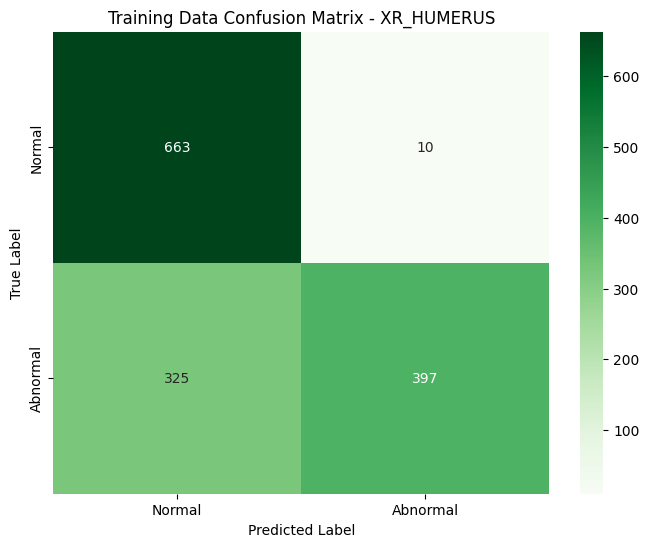


📋 Training Data Classification Report for XR_HUMERUS:
              precision    recall  f1-score   support

      Normal       0.67      0.99      0.80       673
    Abnormal       0.98      0.55      0.70       722

    accuracy                           0.76      1395
   macro avg       0.82      0.77      0.75      1395
weighted avg       0.83      0.76      0.75      1395


📊 Evaluating XR_SHOULDER on training data...
📁 Found 8578 training images for XR_SHOULDER


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_SHOULDER


Evaluating XR_SHOULDER (Training): 100%|█████████████████████████████████████████████| 269/269 [12:41<00:00,  2.83s/it]


📈 Training Data Results for XR_SHOULDER:
   Accuracy:  0.7413 (74.13%)
   Precision: 0.7576
   Recall:    0.7413
   F1-Score:  0.7357


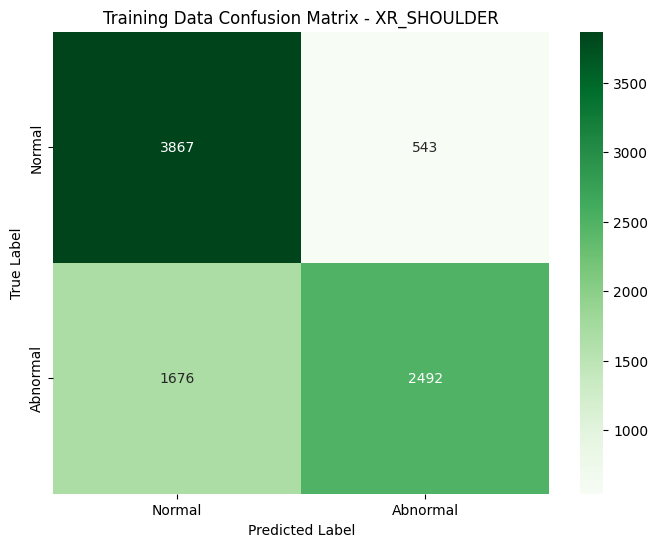


📋 Training Data Classification Report for XR_SHOULDER:
              precision    recall  f1-score   support

      Normal       0.70      0.88      0.78      4410
    Abnormal       0.82      0.60      0.69      4168

    accuracy                           0.74      8578
   macro avg       0.76      0.74      0.73      8578
weighted avg       0.76      0.74      0.74      8578


📊 Evaluating XR_WRIST on training data...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


📁 Found 12187 training images for XR_WRIST
✅ Model loaded successfully for XR_WRIST


Evaluating XR_WRIST (Training): 100%|████████████████████████████████████████████████| 381/381 [22:34<00:00,  3.56s/it]


📈 Training Data Results for XR_WRIST:
   Accuracy:  0.8744 (87.44%)
   Precision: 0.8784
   Recall:    0.8744
   F1-Score:  0.8744


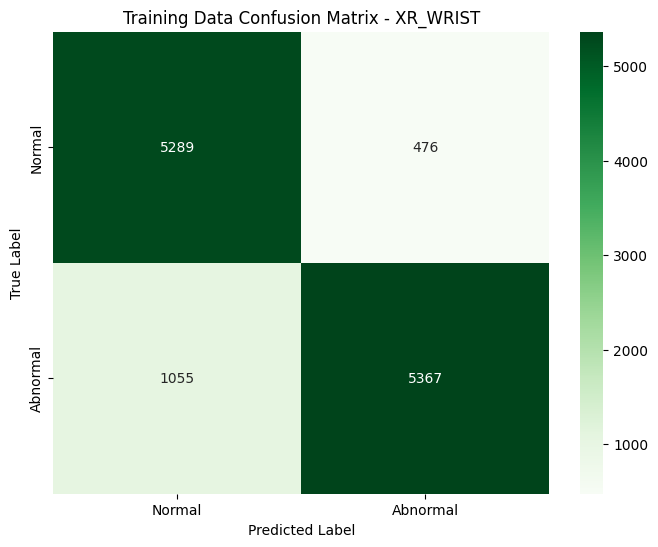


📋 Training Data Classification Report for XR_WRIST:
              precision    recall  f1-score   support

      Normal       0.83      0.92      0.87      5765
    Abnormal       0.92      0.84      0.88      6422

    accuracy                           0.87     12187
   macro avg       0.88      0.88      0.87     12187
weighted avg       0.88      0.87      0.87     12187


📊 TRAINING DATA EVALUATION SUMMARY
             accuracy  precision  recall  f1_score
XR_ELBOW       0.8356     0.8436  0.8356    0.8356
XR_FINGER      0.8275     0.8357  0.8275    0.8279
XR_FOREARM     0.8066     0.8259  0.8066    0.8058
XR_HAND        0.8247     0.8253  0.8247    0.8247
XR_HUMERUS     0.7599     0.8286  0.7599    0.7491
XR_SHOULDER    0.7413     0.7576  0.7413    0.7357
XR_WRIST       0.8744     0.8784  0.8744    0.8744


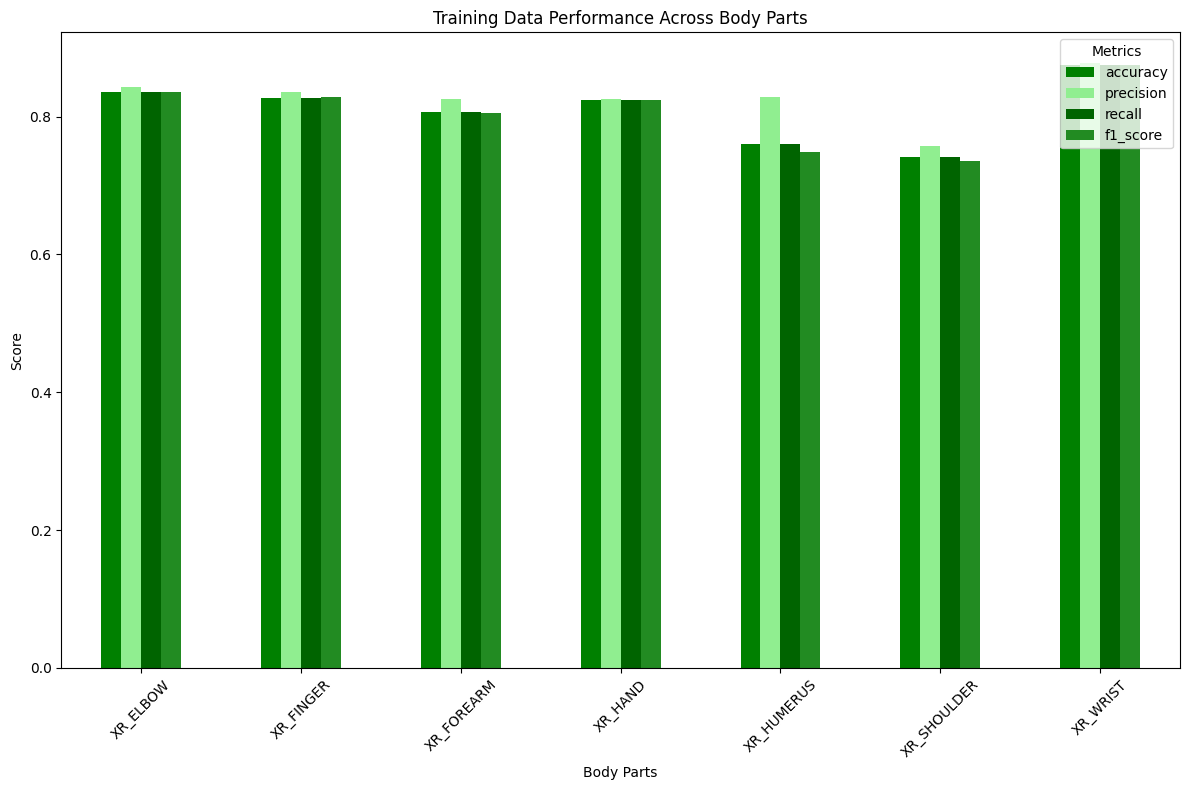


📊 Training Performance Statistics:
   Average Accuracy: 0.8100 ± 0.0458
   Best Training Performance: XR_WRIST (0.8744)
   Lowest Training Performance: XR_SHOULDER (0.7413)

🔍 STEP 3: Evaluating on Validation Data
🔍 Starting Model Evaluation on Validation Data

📊 Evaluating XR_ELBOW...
📁 Found 575 validation images for XR_ELBOW
✅ Model loaded successfully for XR_ELBOW


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Eval


📈 Results for XR_ELBOW:
   Accuracy:  0.8261 (82.61%)
   Precision: 0.8425
   Recall:    0.8261
   F1-Score:  0.8275


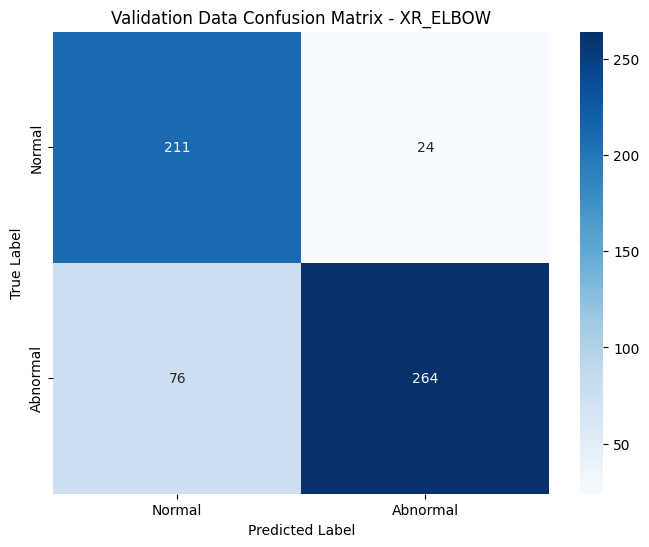


📋 Detailed Classification Report for XR_ELBOW:
              precision    recall  f1-score   support

      Normal       0.74      0.90      0.81       235
    Abnormal       0.92      0.78      0.84       340

    accuracy                           0.83       575
   macro avg       0.83      0.84      0.82       575
weighted avg       0.84      0.83      0.83       575


📊 Evaluating XR_FINGER...
📁 Found 494 validation images for XR_FINGER


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_FINGER


Evaluating XR_FINGER (Validation): 100%|███████████████████████████████████████████████| 16/16 [00:38<00:00,  2.40s/it]


📈 Results for XR_FINGER:
   Accuracy:  0.7652 (76.52%)
   Precision: 0.7782
   Recall:    0.7652
   F1-Score:  0.7662


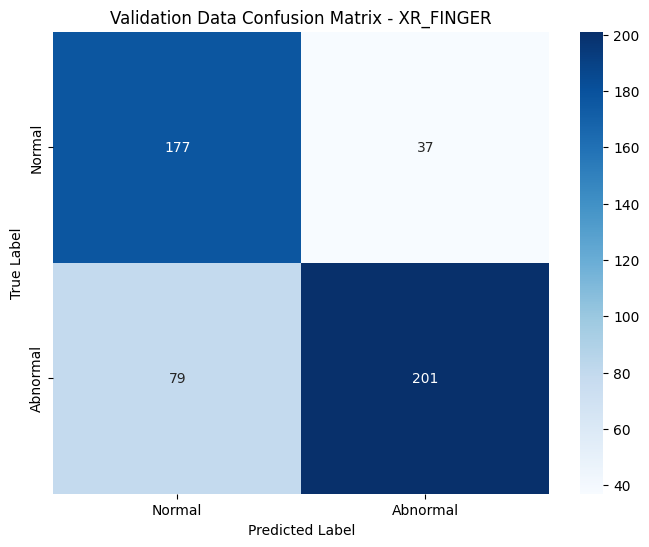


📋 Detailed Classification Report for XR_FINGER:
              precision    recall  f1-score   support

      Normal       0.69      0.83      0.75       214
    Abnormal       0.84      0.72      0.78       280

    accuracy                           0.77       494
   macro avg       0.77      0.77      0.76       494
weighted avg       0.78      0.77      0.77       494


📊 Evaluating XR_FOREARM...
📁 Found 315 validation images for XR_FOREARM


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_FOREARM


Evaluating XR_FOREARM (Validation): 100%|██████████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


📈 Results for XR_FOREARM:
   Accuracy:  0.6730 (67.30%)
   Precision: 0.7001
   Recall:    0.6730
   F1-Score:  0.6663


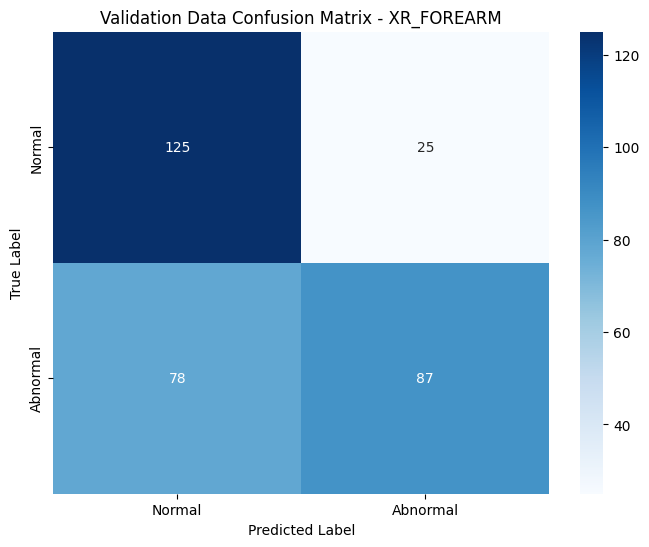


📋 Detailed Classification Report for XR_FOREARM:
              precision    recall  f1-score   support

      Normal       0.62      0.83      0.71       150
    Abnormal       0.78      0.53      0.63       165

    accuracy                           0.67       315
   macro avg       0.70      0.68      0.67       315
weighted avg       0.70      0.67      0.67       315


📊 Evaluating XR_HAND...
📁 Found 565 validation images for XR_HAND


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_HAND


Evaluating XR_HAND (Validation): 100%|█████████████████████████████████████████████████| 18/18 [00:41<00:00,  2.29s/it]


📈 Results for XR_HAND:
   Accuracy:  0.7858 (78.58%)
   Precision: 0.7866
   Recall:    0.7858
   F1-Score:  0.7859


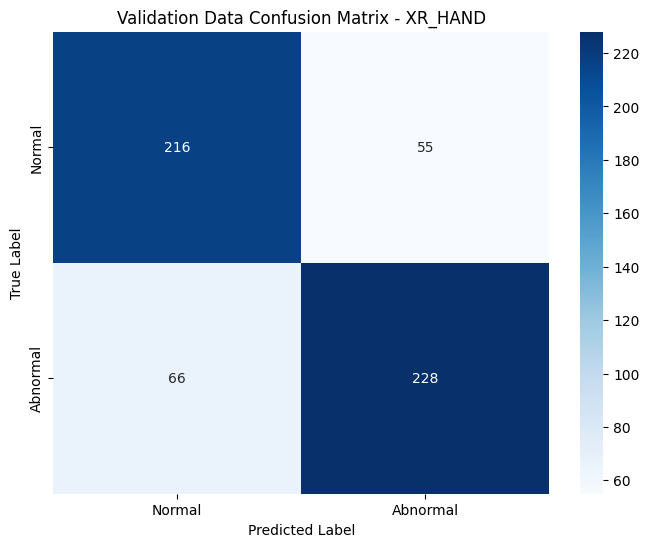


📋 Detailed Classification Report for XR_HAND:
              precision    recall  f1-score   support

      Normal       0.77      0.80      0.78       271
    Abnormal       0.81      0.78      0.79       294

    accuracy                           0.79       565
   macro avg       0.79      0.79      0.79       565
weighted avg       0.79      0.79      0.79       565


📊 Evaluating XR_HUMERUS...
📁 Found 287 validation images for XR_HUMERUS


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_HUMERUS


Evaluating XR_HUMERUS (Validation): 100%|████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.34it/s]


📈 Results for XR_HUMERUS:
   Accuracy:  0.7282 (72.82%)
   Precision: 0.7631
   Recall:    0.7282
   F1-Score:  0.7164


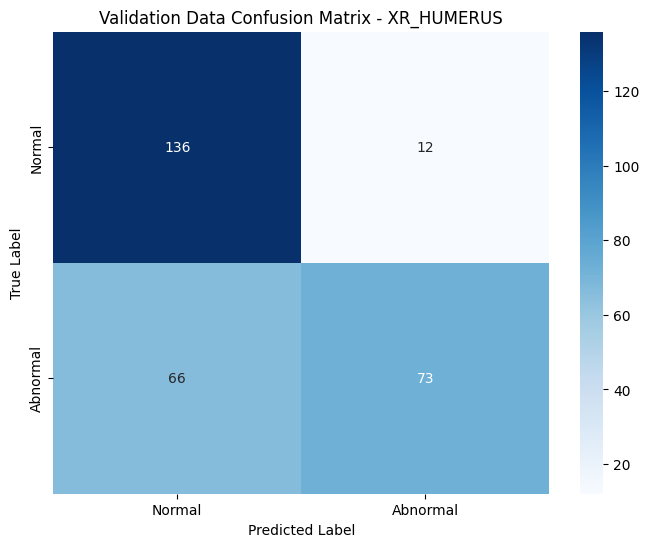


📋 Detailed Classification Report for XR_HUMERUS:
              precision    recall  f1-score   support

      Normal       0.67      0.92      0.78       148
    Abnormal       0.86      0.53      0.65       139

    accuracy                           0.73       287
   macro avg       0.77      0.72      0.71       287
weighted avg       0.76      0.73      0.72       287


📊 Evaluating XR_SHOULDER...
📁 Found 575 validation images for XR_SHOULDER


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully for XR_SHOULDER


Evaluating XR_SHOULDER (Validation): 100%|█████████████████████████████████████████████| 18/18 [00:50<00:00,  2.79s/it]


📈 Results for XR_SHOULDER:
   Accuracy:  0.6991 (69.91%)
   Precision: 0.7112
   Recall:    0.6991
   F1-Score:  0.6953


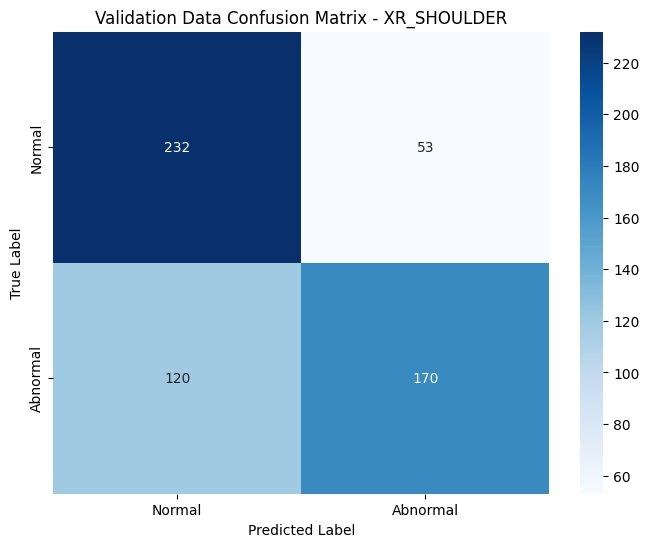


📋 Detailed Classification Report for XR_SHOULDER:
              precision    recall  f1-score   support

      Normal       0.66      0.81      0.73       285
    Abnormal       0.76      0.59      0.66       290

    accuracy                           0.70       575
   macro avg       0.71      0.70      0.70       575
weighted avg       0.71      0.70      0.70       575


📊 Evaluating XR_WRIST...
📁 Found 782 validation images for XR_WRIST
✅ Model loaded successfully for XR_WRIST


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14180\1849720275.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Eval


📈 Results for XR_WRIST:
   Accuracy:  0.8350 (83.50%)
   Precision: 0.8408
   Recall:    0.8350
   F1-Score:  0.8351


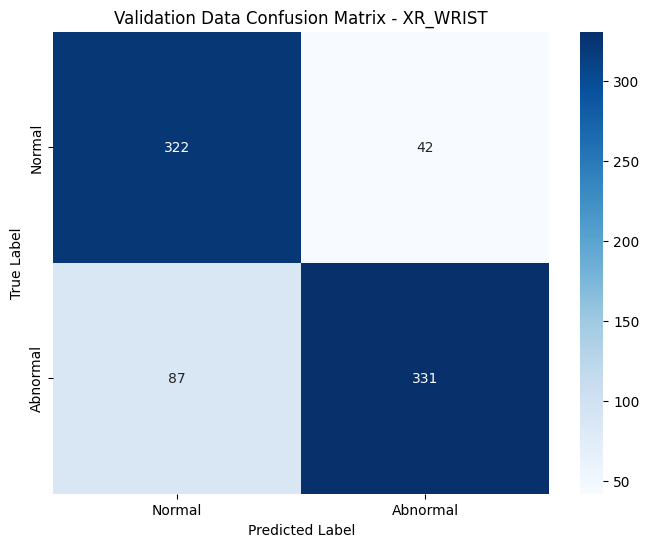


📋 Detailed Classification Report for XR_WRIST:
              precision    recall  f1-score   support

      Normal       0.79      0.88      0.83       364
    Abnormal       0.89      0.79      0.84       418

    accuracy                           0.84       782
   macro avg       0.84      0.84      0.84       782
weighted avg       0.84      0.84      0.84       782


📊 VALIDATION DATA EVALUATION SUMMARY
             accuracy  precision  recall  f1_score
XR_ELBOW       0.8261     0.8425  0.8261    0.8275
XR_FINGER      0.7652     0.7782  0.7652    0.7662
XR_FOREARM     0.6730     0.7001  0.6730    0.6663
XR_HAND        0.7858     0.7866  0.7858    0.7859
XR_HUMERUS     0.7282     0.7631  0.7282    0.7164
XR_SHOULDER    0.6991     0.7112  0.6991    0.6953
XR_WRIST       0.8350     0.8408  0.8350    0.8351


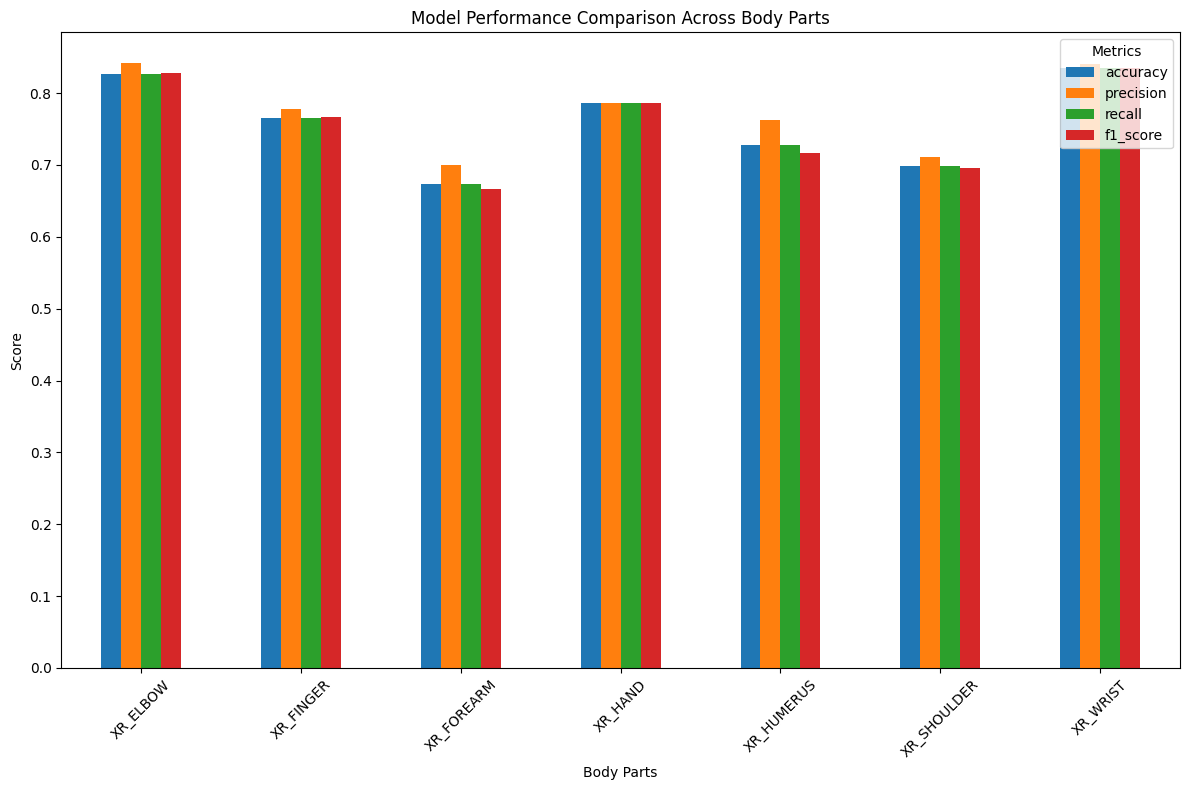


🏆 Best performing model: XR_WRIST (Accuracy: 0.8350)
⚠️ Lowest performing model: XR_FOREARM (Accuracy: 0.6730)
📊 Average Accuracy: 0.7589 ± 0.0619

📈 TRAINING vs VALIDATION COMPARISON


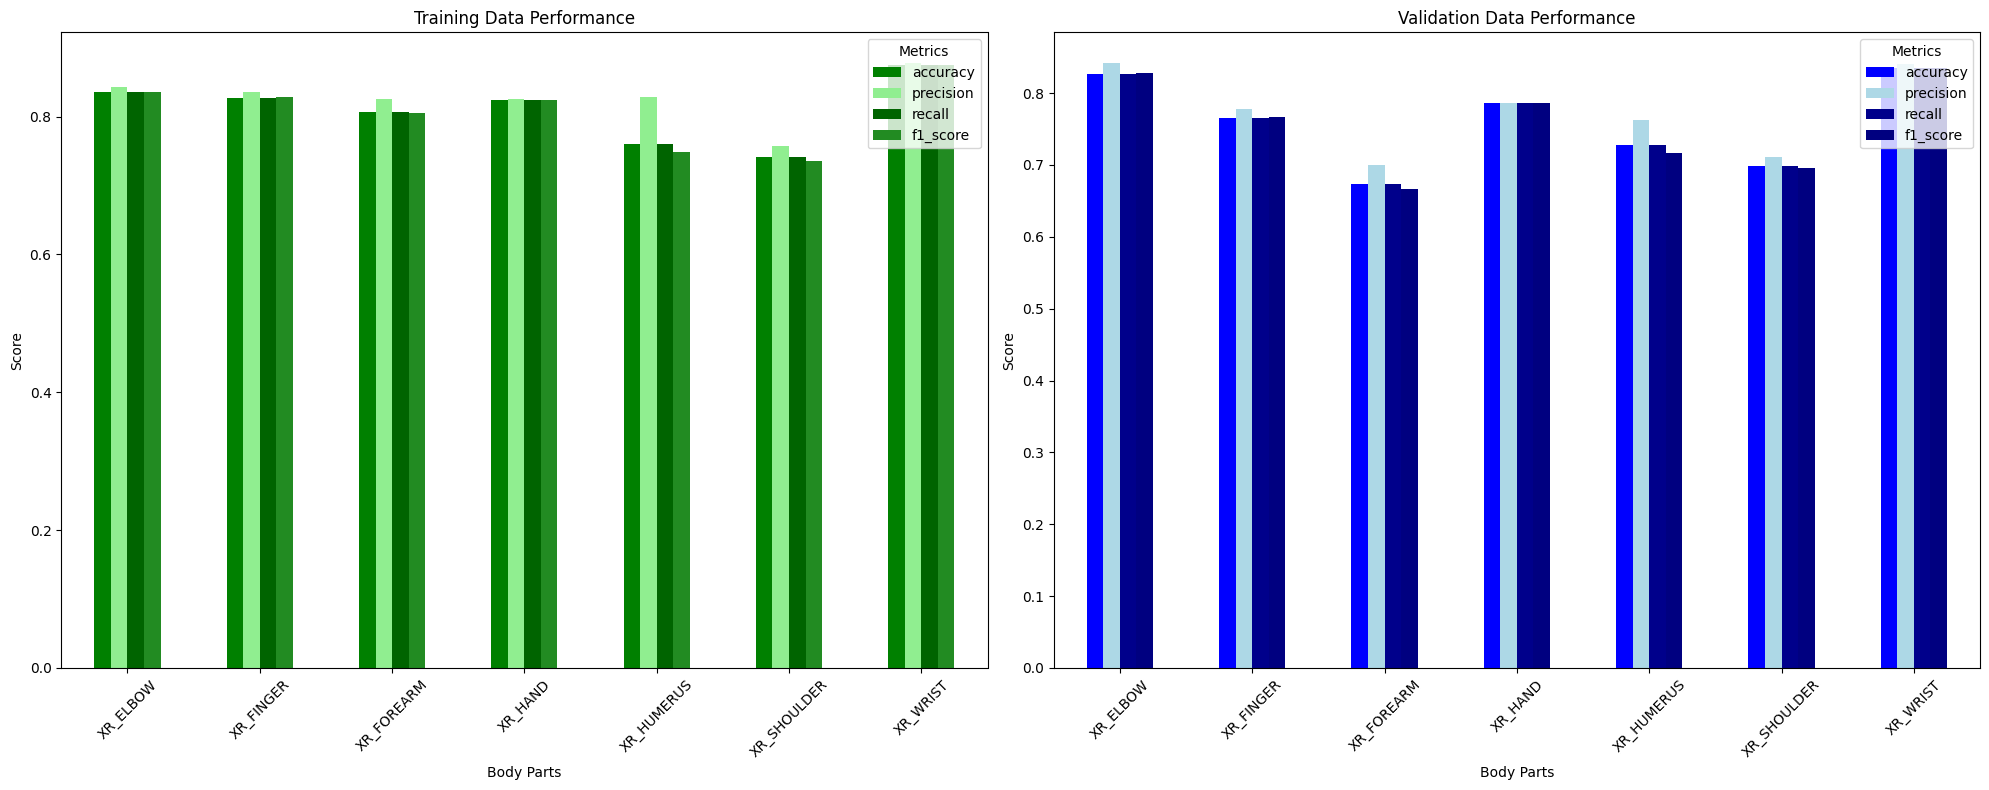


🔍 Overfitting Analysis (Training - Validation Accuracy):
   XR_ELBOW: 0.0095 (✅ Good generalization)
   XR_FINGER: 0.0623 (🔶 Moderate overfitting)
   XR_FOREARM: 0.1336 (⚠️ High overfitting)
   XR_HAND: 0.0389 (✅ Good generalization)
   XR_HUMERUS: 0.0317 (✅ Good generalization)
   XR_SHOULDER: 0.0422 (✅ Good generalization)
   XR_WRIST: 0.0394 (✅ Good generalization)

🎉 Pipeline completed successfully!


In [51]:
# Main execution function
def main():
    print("🚀 Starting MURA Classification Pipeline with Dropout and Balancing")
    print("=" * 60)
    
    print("\n📚 STEP 1: Training Models")
    train_models()
    
    print("\n📊 STEP 2: Evaluating on Training Data")
    training_results = evaluate_training_data()
    
    print("\n🔍 STEP 3: Evaluating on Validation Data")
    validation_results = evaluate_validation_data()
    
    if training_results is not None and validation_results is not None:
        print("\n" + "="*60)
        print("📈 TRAINING vs VALIDATION COMPARISON")
        print("="*60)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        training_results.plot(kind='bar', ax=ax1, color=['green', 'lightgreen', 'darkgreen', 'forestgreen'])
        ax1.set_title('Training Data Performance')
        ax1.set_ylabel('Score')
        ax1.set_xlabel('Body Parts')
        ax1.legend(title='Metrics')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
        
        validation_results.plot(kind='bar', ax=ax2, color=['blue', 'lightblue', 'darkblue', 'navy'])
        ax2.set_title('Validation Data Performance')
        ax2.set_ylabel('Score')
        ax2.set_xlabel('Body Parts')
        ax2.legend(title='Metrics')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        accuracy_diff = training_results['accuracy'] - validation_results['accuracy']
        print(f"\n🔍 Overfitting Analysis (Training - Validation Accuracy):")
        for body_part in accuracy_diff.index:
            diff = accuracy_diff[body_part]
            status = "⚠️ High overfitting" if diff > 0.1 else "🔶 Moderate overfitting" if diff > 0.05 else "✅ Good generalization"
            print(f"   {body_part}: {diff:.4f} ({status})")
    
    print("\n🎉 Pipeline completed successfully!")

if __name__ == "__main__":
    main()

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

# Body part classifier dataset class with proper splits
class BodyPartClassifierDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, split='train', test_size=0.2, val_size=0.2, random_state=42):
        self.data = pd.read_csv(csv_file, header=None, names=['path', 'label'])
        self.root_dir = root_dir
        self.transform = transform
        
        # Create mapping from body part names to indices
        self.body_parts = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
        self.body_part_to_idx = {part: idx for idx, part in enumerate(self.body_parts)}
        
        # Create a list of all image paths and their corresponding body part labels
        all_image_paths = []
        all_body_part_labels = []
        all_study_ids = []  # To ensure studies don't leak between splits
        
        for idx, row in self.data.iterrows():
            # Extract body part from path
            body_part = None
            for part in self.body_parts:
                if part in row['path']:
                    body_part = part
                    break
            
            if body_part is None:
                continue
                
            study_path = os.path.join(self.root_dir, row['path'].replace('MURA-v1.1/', ''))
            if os.path.exists(study_path):
                try:
                    images_in_study = []
                    for img_name in os.listdir(study_path):
                        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                            images_in_study.append(os.path.join(study_path, img_name))
                    
                    # Add all images from this study
                    for img_path in images_in_study:
                        all_image_paths.append(img_path)
                        all_body_part_labels.append(self.body_part_to_idx[body_part])
                        all_study_ids.append(row['path'])  # Use study path as unique identifier
                        
                except PermissionError:
                    print(f"Permission denied accessing {study_path}")
                    continue
            else:
                print(f"Path does not exist: {study_path}")
        
        # Create DataFrame for splitting
        df = pd.DataFrame({
            'image_path': all_image_paths,
            'body_part_label': all_body_part_labels,
            'study_id': all_study_ids
        })
        
        # Group by study_id to ensure studies don't leak between splits
        study_groups = df.groupby('study_id').first().reset_index()
        
        # Split studies first (stratified by body part)
        train_studies, temp_studies = train_test_split(
            study_groups, 
            test_size=(test_size + val_size),
            stratify=study_groups['body_part_label'],
            random_state=random_state
        )
        
        # Split remaining into validation and test
        val_studies, test_studies = train_test_split(
            temp_studies,
            test_size=test_size / (test_size + val_size),
            stratify=temp_studies['body_part_label'],
            random_state=random_state
        )
        
        # Get images for the requested split
        if split == 'train':
            selected_studies = set(train_studies['study_id'])
        elif split == 'val':
            selected_studies = set(val_studies['study_id'])
        elif split == 'test':
            selected_studies = set(test_studies['study_id'])
        else:
            raise ValueError("Split must be 'train', 'val', or 'test'")
        
        # Filter images based on selected studies
        split_df = df[df['study_id'].isin(selected_studies)]
        
        self.image_paths = split_df['image_path'].tolist()
        self.body_part_labels = split_df['body_part_label'].tolist()
        
        # Print split information
        print(f"\n📊 {split.upper()} Split Information:")
        print(f"   Total images: {len(self.image_paths)}")
        print(f"   Total studies: {len(selected_studies)}")
        
        # Print body part distribution
        label_counts = Counter(self.body_part_labels)
        for part_idx, count in label_counts.items():
            part_name = self.body_parts[part_idx]
            print(f"   {part_name}: {count} images")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            body_part_label = self.body_part_labels[idx]
            
            if self.transform:
                image = self.transform(image)
            
            return image, body_part_label
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            if self.transform:
                image = self.transform(Image.new('RGB', (224, 224), (0, 0, 0)))
            else:
                image = Image.new('RGB', (224, 224), (0, 0, 0))
            return image, 0


In [59]:
# Body part classifier model
class BodyPartClassifier(nn.Module):
    def __init__(self, num_body_parts=7, dropout_rate=0.2):
        super(BodyPartClassifier, self).__init__()
        try:
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        except:
            self.backbone = models.resnet18(pretrained=True)
        
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_body_parts)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [67]:
# Function to train body part classifier with proper splits
def train_body_part_classifier():
    print("🎯 Training Body Part Classifier with Proper Splits")
    print("=" * 60)
    
    root_dir = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1"
    valid_csv = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1\valid_labeled_studies.csv"
    
    if not os.path.exists(root_dir) or not os.path.exists(valid_csv):
        print(f"Required files not found!")
        return None
    
    # Check if body part classifier already exists
    model_path = 'body_part_classifier_split.pth'
    if os.path.exists(model_path):
        print(f"✅ Body part classifier already exists at {model_path}")
        return model_path
    
    # Create datasets with proper splits
    print("📁 Creating train/validation/test splits...")
    train_dataset = BodyPartClassifierDataset(
        csv_file=valid_csv, 
        root_dir=root_dir, 
        transform=transform, 
        split='train',
        test_size=0.15,  # 15% for test
        val_size=0.15,   # 15% for validation
        random_state=42  # 70% for training
    )
    
    val_dataset = BodyPartClassifierDataset(
        csv_file=valid_csv, 
        root_dir=root_dir, 
        transform=transform, 
        split='val',
        test_size=0.15,
        val_size=0.15,
        random_state=42
    )
    
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print("❌ No images found for body part classification")
        return None
    
    print(f"\n📊 Dataset Split Summary:")
    print(f"   Training: {len(train_dataset)} images")
    print(f"   Validation: {len(val_dataset)} images")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Initialize model
    model = BodyPartClassifier(num_body_parts=7, dropout_rate=0.2)
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Training loop with validation
    num_epochs = 25
    best_val_acc = 0.0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_desc = f"Epoch {epoch+1}/{num_epochs} [Training]"
        train_bar = tqdm(train_loader, desc=train_desc, leave=False)
        
        for batch_idx, (images, labels) in enumerate(train_bar):
            try:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                current_loss = train_loss / (batch_idx + 1)
                current_acc = 100 * train_correct / train_total if train_total > 0 else 0
                train_bar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.2f}%'})
                
            except RuntimeError as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_desc = f"Epoch {epoch+1}/{num_epochs} [Validation]"
            val_bar = tqdm(val_loader, desc=val_desc, leave=False)
            
            for batch_idx, (images, labels) in enumerate(val_bar):
                try:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    
                    current_loss = val_loss / (batch_idx + 1)
                    current_acc = 100 * val_correct / val_total if val_total > 0 else 0
                    val_bar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.2f}%'})
                    
                except RuntimeError as e:
                    print(f"Error in validation batch {batch_idx}: {e}")
                    continue
        
        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
        epoch_train_acc = 100 * train_correct / train_total if train_total > 0 else 0
        epoch_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        epoch_val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
        
        # Step scheduler
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%')
        print(f'  Val   - Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%')
        print(f'  Best Val Acc: {best_val_acc:.2f}%')
        print('-' * 50)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Save model
    torch.save({
        'model_state_dict': best_model_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_accuracy': best_val_acc,
        'epochs_trained': num_epochs,
        'body_parts': train_dataset.body_parts,
        'body_part_to_idx': train_dataset.body_part_to_idx,
        'dropout_rate': 0.2,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, model_path)
    
    print(f'✅ Body part classifier saved to {model_path}')
    print(f'✅ Training completed! Best validation accuracy: {best_val_acc:.2f}%')
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best Val Acc: {best_val_acc:.2f}%')
    plt.title('Validation Accuracy Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model_path

In [69]:
# Function to load body part classifier
def load_body_part_classifier(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = BodyPartClassifier(num_body_parts=7, dropout_rate=0.2)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    body_parts = checkpoint['body_parts']
    return model, body_parts

# Function to evaluate body part classifier on test set
def evaluate_body_part_classifier():
    print("📊 Evaluating Body Part Classifier on Test Set")
    print("=" * 50)
    
    root_dir = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1"
    valid_csv = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1\valid_labeled_studies.csv"
    
    # Check if model exists
    model_path = 'body_part_classifier_split.pth'
    if not os.path.exists(model_path):
        print("❌ Body part classifier not found! Please train it first.")
        return
    
    # Load model
    model, body_parts = load_body_part_classifier(model_path, device)
    print("✅ Body part classifier loaded successfully")
    
    # Create test dataset
    test_dataset = BodyPartClassifierDataset(
        csv_file=valid_csv, 
        root_dir=root_dir, 
        transform=transform, 
        split='test',
        test_size=0.15,
        val_size=0.15,
        random_state=42
    )
    
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Evaluate
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on test set"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    print(f"\n🎯 Test Set Results:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=body_parts,
                yticklabels=body_parts)
    plt.title('Body Part Classification Confusion Matrix (Test Set)')
    plt.ylabel('True Body Part')
    plt.xlabel('Predicted Body Part')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Detailed classification report
    print(f"\n📋 Detailed Test Set Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=body_parts))
    
    # Load and display training history
    checkpoint = torch.load(model_path, map_location=device)
    if 'best_val_accuracy' in checkpoint:
        print(f"\n📈 Training Summary:")
        print(f"   Best Validation Accuracy: {checkpoint['best_val_accuracy']:.2f}%")
        print(f"   Final Test Accuracy: {accuracy*100:.2f}%")
        print(f"   Epochs Trained: {checkpoint['epochs_trained']}")
    
    print("✅ Body part classifier evaluation completed!")

# Function to evaluate on validation set (for comparison)
def evaluate_body_part_classifier_validation():
    print("📊 Evaluating Body Part Classifier on Validation Set")
    print("=" * 50)
    
    root_dir = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1"
    valid_csv = r"C:\Users\ASUS\OneDrive\Desktop\Mura\MURA-v1.1\valid_labeled_studies.csv"
    
    # Check if model exists
    model_path = 'body_part_classifier_split.pth'
    if not os.path.exists(model_path):
        print("❌ Body part classifier not found! Please train it first.")
        return
    
    # Load model
    model, body_parts = load_body_part_classifier(model_path, device)
    print("✅ Body part classifier loaded successfully")
    
    # Create validation dataset
    val_dataset = BodyPartClassifierDataset(
        csv_file=valid_csv, 
        root_dir=root_dir, 
        transform=transform, 
        split='val',
        test_size=0.15,
        val_size=0.15,
        random_state=42
    )
    
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Evaluate
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating on validation set"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    print(f"\n🎯 Validation Set Results:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    print("✅ Validation set evaluation completed!")

🎯 Body Part Classifier with Proper Train/Val/Test Split
🎯 Training Body Part Classifier with Proper Splits
📁 Creating train/validation/test splits...

📊 TRAIN Split Information:
   Total images: 2275
   Total studies: 839
   XR_WRIST: 467 images
   XR_FOREARM: 212 images
   XR_HAND: 328 images
   XR_HUMERUS: 204 images
   XR_SHOULDER: 400 images
   XR_ELBOW: 335 images
   XR_FINGER: 329 images

📊 VAL Split Information:
   Total images: 446
   Total studies: 180
   XR_WRIST: 96 images
   XR_FOREARM: 44 images
   XR_HAND: 66 images
   XR_HUMERUS: 42 images
   XR_SHOULDER: 76 images
   XR_ELBOW: 58 images
   XR_FINGER: 64 images

📊 Dataset Split Summary:
   Training: 2275 images
   Validation: 446 images


Epoch 1/25:
  Train - Loss: 0.7153, Acc: 76.44%
  Val   - Loss: 1.1591, Acc: 70.40%
  Best Val Acc: 70.40%
--------------------------------------------------


Epoch 2/25:
  Train - Loss: 0.5102, Acc: 83.96%
  Val   - Loss: 0.4975, Acc: 84.98%
  Best Val Acc: 84.98%
--------------------------------------------------


Epoch 3/25:
  Train - Loss: 0.4419, Acc: 86.24%
  Val   - Loss: 0.6086, Acc: 83.86%
  Best Val Acc: 84.98%
--------------------------------------------------


Epoch 4/25:
  Train - Loss: 0.4053, Acc: 87.65%
  Val   - Loss: 0.6155, Acc: 80.27%
  Best Val Acc: 84.98%
--------------------------------------------------


Epoch 5/25:
  Train - Loss: 0.3531, Acc: 88.97%
  Val   - Loss: 0.4964, Acc: 86.77%
  Best Val Acc: 86.77%
--------------------------------------------------


Epoch 6/25:
  Train - Loss: 0.3078, Acc: 91.34%
  Val   - Loss: 0.4748, Acc: 86.55%
  Best Val Acc: 86.77%
--------------------------------------------------


Epoch 7/25:
  Train - Loss: 0.2794, Acc: 90.95%
  Val   - Loss: 0.3159, Acc: 90.13%
  Best Val Acc: 90.13%
--------------------------------------------------


Epoch 8/25:
  Train - Loss: 0.2420, Acc: 92.97%
  Val   - Loss: 0.2852, Acc: 92.15%
  Best Val Acc: 92.15%
--------------------------------------------------


Epoch 9/25:
  Train - Loss: 0.1883, Acc: 93.71%
  Val   - Loss: 0.4163, Acc: 88.57%
  Best Val Acc: 92.15%
--------------------------------------------------


Epoch 10/25:
  Train - Loss: 0.2752, Acc: 92.18%
  Val   - Loss: 0.6711, Acc: 83.63%
  Best Val Acc: 92.15%
--------------------------------------------------


Epoch 11/25:
  Train - Loss: 0.1902, Acc: 94.81%
  Val   - Loss: 0.2706, Acc: 93.50%
  Best Val Acc: 93.50%
--------------------------------------------------


Epoch 12/25:
  Train - Loss: 0.1084, Acc: 97.05%
  Val   - Loss: 0.2553, Acc: 94.62%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 13/25:
  Train - Loss: 0.0995, Acc: 97.49%
  Val   - Loss: 0.2560, Acc: 93.27%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 14/25:
  Train - Loss: 0.0965, Acc: 97.67%
  Val   - Loss: 0.2545, Acc: 92.83%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 15/25:
  Train - Loss: 0.0964, Acc: 97.01%
  Val   - Loss: 0.2726, Acc: 93.95%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 16/25:
  Train - Loss: 0.0818, Acc: 97.85%
  Val   - Loss: 0.2502, Acc: 94.62%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 17/25:
  Train - Loss: 0.0631, Acc: 98.07%
  Val   - Loss: 0.2855, Acc: 93.50%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 18/25:
  Train - Loss: 0.0555, Acc: 98.37%
  Val   - Loss: 0.2972, Acc: 93.50%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 19/25:
  Train - Loss: 0.0674, Acc: 98.55%
  Val   - Loss: 0.2884, Acc: 92.83%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 20/25:
  Train - Loss: 0.0543, Acc: 98.33%
  Val   - Loss: 0.2823, Acc: 93.50%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 21/25:
  Train - Loss: 0.0400, Acc: 98.77%
  Val   - Loss: 0.2673, Acc: 93.27%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 22/25:
  Train - Loss: 0.0396, Acc: 99.12%
  Val   - Loss: 0.2995, Acc: 92.60%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 23/25:
  Train - Loss: 0.0377, Acc: 99.08%
  Val   - Loss: 0.2927, Acc: 92.38%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 24/25:
  Train - Loss: 0.0372, Acc: 98.95%
  Val   - Loss: 0.2947, Acc: 93.05%
  Best Val Acc: 94.62%
--------------------------------------------------


Epoch 25/25:
  Train - Loss: 0.0332, Acc: 98.99%
  Val   - Loss: 0.2828, Acc: 93.50%
  Best Val Acc: 94.62%
--------------------------------------------------
✅ Body part classifier saved to body_part_classifier_split.pth
✅ Training completed! Best validation accuracy: 94.62%


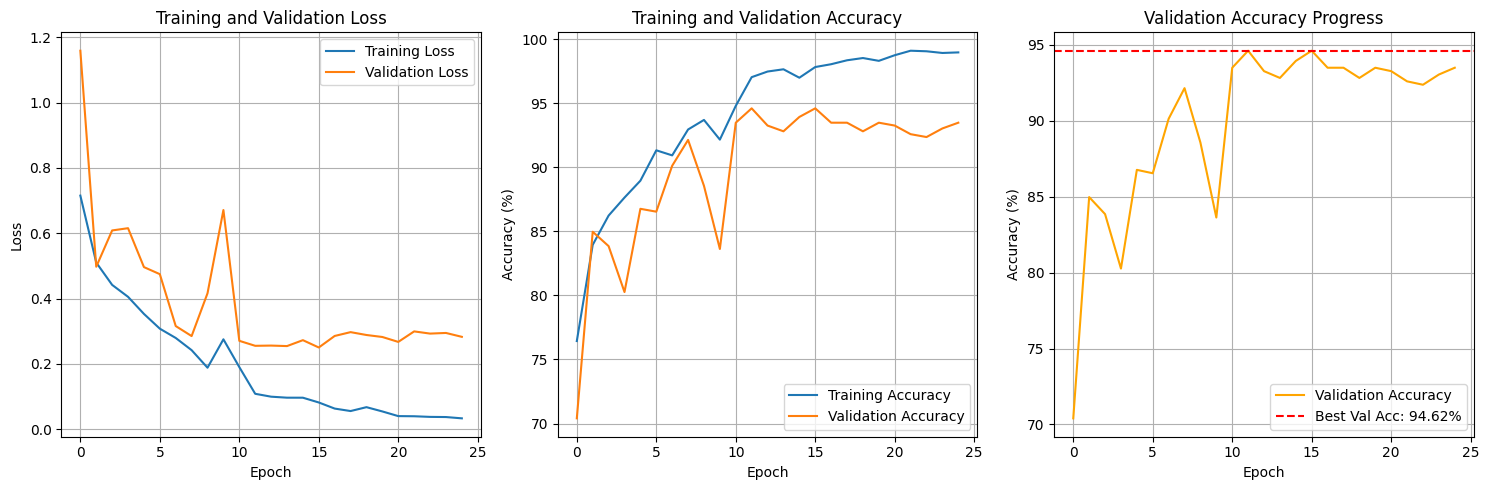


📊 EVALUATION PHASE
📊 Evaluating Body Part Classifier on Validation Set
✅ Body part classifier loaded successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18292\2860294170.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



📊 VAL Split Information:
   Total images: 446
   Total studies: 180
   XR_WRIST: 96 images
   XR_FOREARM: 44 images
   XR_HAND: 66 images
   XR_HUMERUS: 42 images
   XR_SHOULDER: 76 images
   XR_ELBOW: 58 images
   XR_FINGER: 64 images


Evaluating on validation set: 100%|████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.75it/s]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18292\2860294170.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Git


🎯 Validation Set Results:
   Accuracy:  0.9395 (93.95%)
   Precision: 0.9405
   Recall:    0.9395
   F1-Score:  0.9395
✅ Validation set evaluation completed!

--------------------------------------------------
📊 Evaluating Body Part Classifier on Test Set
✅ Body part classifier loaded successfully

📊 TEST Split Information:
   Total images: 476
   Total studies: 180
   XR_WRIST: 96 images
   XR_FOREARM: 45 images
   XR_HAND: 66 images
   XR_HUMERUS: 42 images
   XR_SHOULDER: 87 images
   XR_ELBOW: 72 images
   XR_FINGER: 68 images


Evaluating on test set: 100%|██████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.77it/s]


🎯 Test Set Results:
   Accuracy:  0.9223 (92.23%)
   Precision: 0.9252
   Recall:    0.9223
   F1-Score:  0.9221


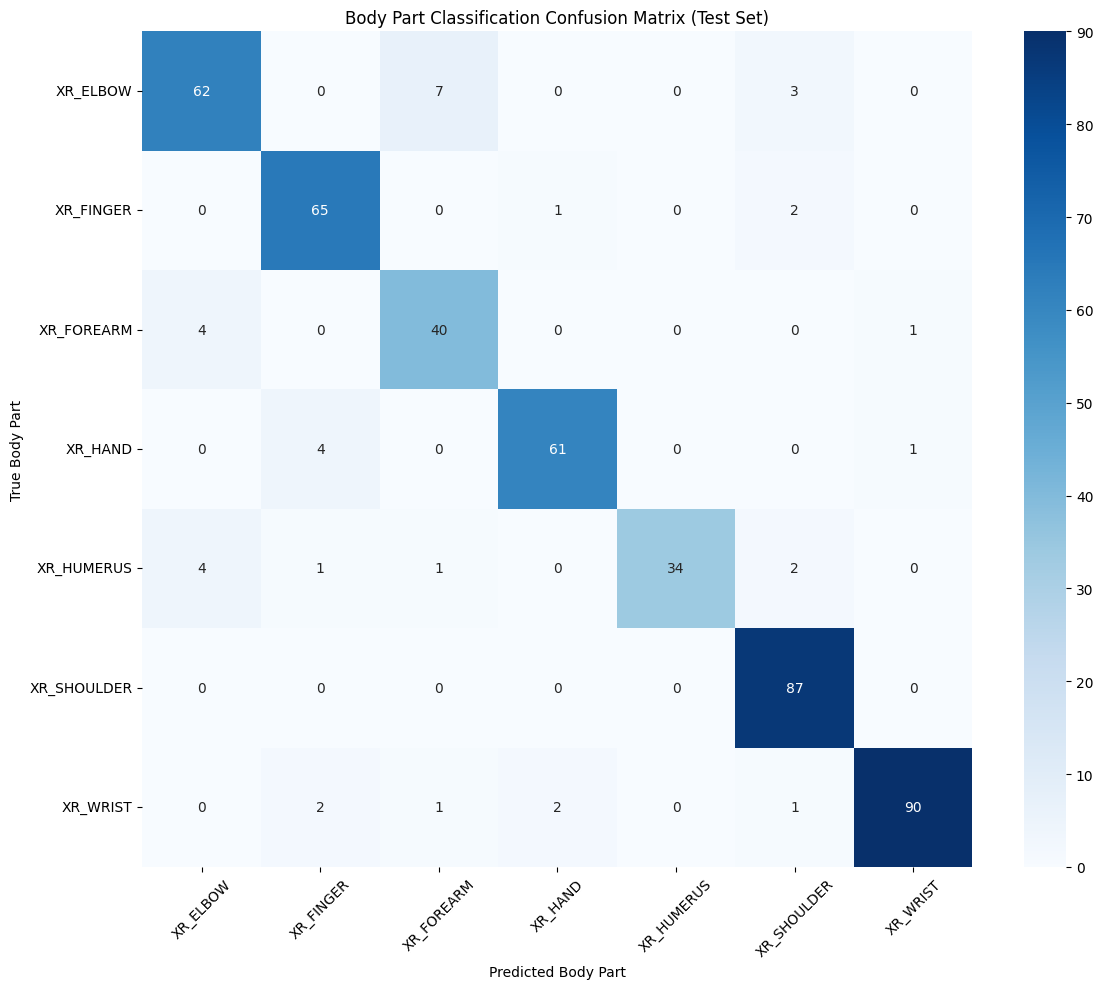


📋 Detailed Test Set Classification Report:
              precision    recall  f1-score   support

    XR_ELBOW       0.89      0.86      0.87        72
   XR_FINGER       0.90      0.96      0.93        68
  XR_FOREARM       0.82      0.89      0.85        45
     XR_HAND       0.95      0.92      0.94        66
  XR_HUMERUS       1.00      0.81      0.89        42
 XR_SHOULDER       0.92      1.00      0.96        87
    XR_WRIST       0.98      0.94      0.96        96

    accuracy                           0.92       476
   macro avg       0.92      0.91      0.91       476
weighted avg       0.93      0.92      0.92       476


📈 Training Summary:
   Best Validation Accuracy: 94.62%
   Final Test Accuracy: 92.23%
   Epochs Trained: 25
✅ Body part classifier evaluation completed!

🎉 Body part classifier pipeline completed successfully!

Key Improvements:
✅ Proper train/validation/test split (70%/15%/15%)
✅ Study-level splitting (no data leakage)
✅ Stratified splitting (balanced bo

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18292\2860294170.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [71]:
# Main function to run body part classifier training and evaluation
def main_body_part_classifier():
    print("🎯 Body Part Classifier with Proper Train/Val/Test Split")
    print("=" * 70)
    
    # Train body part classifier
    model_path = train_body_part_classifier()
    
    if model_path:
        print("\n" + "="*50)
        print("📊 EVALUATION PHASE")
        print("="*50)
        
        # Evaluate on validation set
        evaluate_body_part_classifier_validation()
        
        print("\n" + "-"*50)
        
        # Evaluate on test set (final unbiased evaluation)
        evaluate_body_part_classifier()
        
        print("\n🎉 Body part classifier pipeline completed successfully!")
        print("\nKey Improvements:")
        print("✅ Proper train/validation/test split (70%/15%/15%)")
        print("✅ Study-level splitting (no data leakage)")
        print("✅ Stratified splitting (balanced body part distribution)")
        print("✅ Training curves visualization")
        print("✅ Best model selection based on validation accuracy")
        print("✅ Unbiased test set evaluation")
    else:
        print("❌ Body part classifier training failed!")

# Run the body part classifier with proper splits
if __name__ == "__main__":
    main_body_part_classifier()